Very dumbed-down version of what they do here: "Experimental Bayesian Calibration of Trapped-Ion Entangling Operations" (https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020350).

- Instead of a simultaneous 4D calibration, here we do 4 1D calibrations. 
- Instead of cubic-spline interpolation, we do direct sampling. 
- Instead of a variable measurement strategy that minimizes the variance of the posterior based on sensitivity to phase and Rabi frequency, we go with a constant measurement strategy. 

Original noise parameters ($\sigma_\Omega, \sigma_\Delta, \sigma_\epsilon, \sigma_I$) based on the original paper (see Fig. 4)

Derivative noise parameters ($\sigma_I, \sigma_{f_{cl}}, \sigma_{\nu}$) based on **single_qubit_rotations/single_qubit_noise_sim.ipynb**.

In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  8.073205 seconds (14.89 M allocations: 957.963 MiB, 7.63% gc time, 99.58% compilation time: <1% of which was recompilation)


In [2]:
using QuantumOptics
import PyPlot
using Random, Distributions
using ProgressBars
Random.seed!(0)

include("./molmer_sorensen.jl")
using .MolmerSorensen: construct_MS_chamber
const plt = PyPlot;

using DelimitedFiles
using CSV
using DataFrames
using StringEncodings

The Molmer-Sorensen Hamiltonian: $\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

## 0. Setup

Global variables

In [35]:
######################### Optimal parameter values #########################
# See molmer_sorensen_scans_zoomed.ipynb for how these were determined
INTENSITY_MS = 94326.65907221894 # W/cm^2
TRAP_FREQUENCY = 2.5e5 # Hz
WAVELENGTH_CL_MS = 7.291469940286511e-7 # m
B_STRENGTH = 0.0005999899999999999; # T
PHASE = 0 # radians

######################### Parameter noise values #########################
# See molmer_sorensen_noise_sim.ipynb for how these were determined

# Intensity 
Ω_opt = 1e7
κ = INTENSITY_MS/(Ω_opt^2)
σ_Ω = 0.2Ω_opt
σ_I = κ*sqrt(2*(σ_Ω^4) + 4*(σ_Ω^2)*Ω_opt^2 )

Normal_I = Normal(INTENSITY_MS, σ_I)

# Center-line frequency
δλ_MAX = 1e-15
C0 = 2.99792458e8
FREQUENCY_CL_MS = C0/WAVELENGTH_CL_MS
σ_f_cl = 2e3

Normal_f_cl = Normal(FREQUENCY_CL_MS, σ_f_cl)

# Trap frequency
σΔ = 2e3
σ_ν = σΔ
Normal_ν  = Normal(TRAP_FREQUENCY, σ_ν)

# Phase
σ_ϕ = 0.16*π
Normal_ϕ = Normal(PHASE, σ_ϕ)

######################### Other global variables #########################

CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
N_PARTICLES = Int(1e3)
FINITE_RWA_CUTOFF = 1e5

TIMESCALE = 1e-6 # seconds 
DETUNING = 1e4 # Hz
GATE_TIME = 1/DETUNING # seconds
T_RANGE = 0:GATE_TIME*1e-3:GATE_TIME
AC_CORRECTION = 0; # Hz
PI_TIME = 2e-6

# Intialize chamber object, whose properties will be updated in the loop
MS_CHAMBER_TUNED = construct_MS_chamber(
    TRAP_FREQUENCY,
    INTENSITY_MS,
    WAVELENGTH_CL_MS,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)

VIB_MODE = IonSim.modes(MS_CHAMBER_TUNED)[1] # first vibrational mode
ket0_VIB_MODE = VIB_MODE[0]
dm0_VIB_MODE = dm(ket0_VIB_MODE)

# Computational states 
ket_00 = CALCIUM40["S"] ⊗ CALCIUM40["S"]
ket_01 = CALCIUM40["S"] ⊗ CALCIUM40["D"]
ket_10 = CALCIUM40["D"] ⊗ CALCIUM40["S"]
ket_11 = CALCIUM40["D"] ⊗ CALCIUM40["D"]
ρ_00 = dm(ket_00)
ρ_01 = dm(ket_01)
ρ_10 = dm(ket_10)
ρ_11 = dm(ket_11)

# Bell states 
ket_00_m_i11 = (ket_00 - 1im*ket_11)/√2
ket_00_p_i11 = (ket_00 + 1im*ket_11)/√2
ket_01_m_i10 = (ket_01 - 1im*ket_10)/√2
ket_01_p_i10 = (ket_01 + 1im*ket_10)/√2
ρ_00_m_i11 = dm(ket_00_m_i11)
ρ_00_p_i11 = dm(ket_00_p_i11)
ρ_01_m_i10 = dm(ket_01_m_i10)
ρ_01_p_i10 = dm(ket_01_p_i10);

Helper functions 

In [36]:
# For loading CSV's into matrices 
function load_csv_to_matrix(fname)
    data = readdlm(fname)
    data = [split(line, ",") for line in data]
    data = [[parse(Float64, elem) for elem in row] for row in data]

    matrix = zeros((length(data), length(data[1])))
    for i in 1:length(data)
        matrix[i,:] = [elem for elem in data[i]]
    end
    return matrix
end

# For measuring ZZ
function ZZ_probs(ψf) # random projective measurement onto the computational basis
    p_00 = real(tr(ρ_00 * ψf))
    p_11 = real(tr(ρ_11 * ψf))
    p_01 = real(tr(ρ_01 * ψf))
    p_10 = real(tr(ρ_10 * ψf))

    return p_00, p_11, p_01, p_10
end

# For plotting state populations 
function plot_populations_double(chamber, tout, sol; title = Nothing)

    # compute expectation values
    prob_00 = expect(ρ_00 ⊗ dm0_VIB_MODE , sol)  # 𝔼(|S⟩|S⟩)
    prob_11 = expect(ρ_11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|D⟩|D⟩)
    prob_01 = expect(ρ_01 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩)
    prob_10 = expect(ρ_10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|D⟩|S⟩)
    prob_00_p_i11 = expect(ρ_00_p_i11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|S⟩ + i|D⟩|D⟩)
    prob_00_m_i11 = expect(ρ_00_m_i11 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|S⟩ - i|D⟩|D⟩)
    prob_01_p_i10 = expect(ρ_01_p_i10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩ + i|D⟩|S⟩)
    prob_01_m_i10 = expect(ρ_01_m_i10 ⊗ dm0_VIB_MODE, sol)  # 𝔼(|S⟩|D⟩ - i|D⟩|S⟩)

    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(tout, prob_00, label="00")
    ax1.plot(tout, prob_11, label="11")
    ax1.plot(tout, prob_01, label="01")
    ax1.plot(tout, prob_10, label="10")
    ax1.set_xlim(tout[1], tout[end])
    ax1.set_ylim(0, 1)
    ax1.legend(loc=1)
    ax1.set_xlabel("Time (μs)")
    ax1.set_ylabel("Population")
    ax1.set_title("Computational basis states")

    ax2.plot(tout, prob_00_p_i11, label="00 + i11")
    ax2.plot(tout, prob_00_m_i11, label="00 - i11")
    ax2.plot(tout, prob_01_p_i10, label="01 + i10")
    ax2.plot(tout, prob_01_m_i10, label="01 - i10")
    ax2.set_xlim(tout[1], tout[end])
    ax2.set_ylim(0, 1)
    ax2.legend(loc=1)
    ax2.set_xlabel("Time (μs)")
    ax2.set_ylabel("Population")
    ax2.set_title("Bell states")
    if title != Nothing
        fig.suptitle(title)
    end

    return fig
end

# For binning probability distributions
function bin_prior(particles, weights, n_bins)
    new_bins = zeros(n_bins)
    new_weights = zeros(n_bins)
    bin_width = (maximum(particles) - minimum(particles))/n_bins
    
    for i in 1:n_bins
        bin_start = minimum(particles) + (i-1)*bin_width
        bin_end = bin_start + bin_width
        new_bins[i] = mean([bin_start, bin_end])

        bin_filter = (particles .>= bin_start).&(particles .< bin_end)
        weight_in_bin = sum(weights[bin_filter])
        new_weights[i] = weight_in_bin
        
    end
    return new_bins, new_weights, bin_width
end

bin_prior (generic function with 1 method)

Test fidelity with optimal parameters

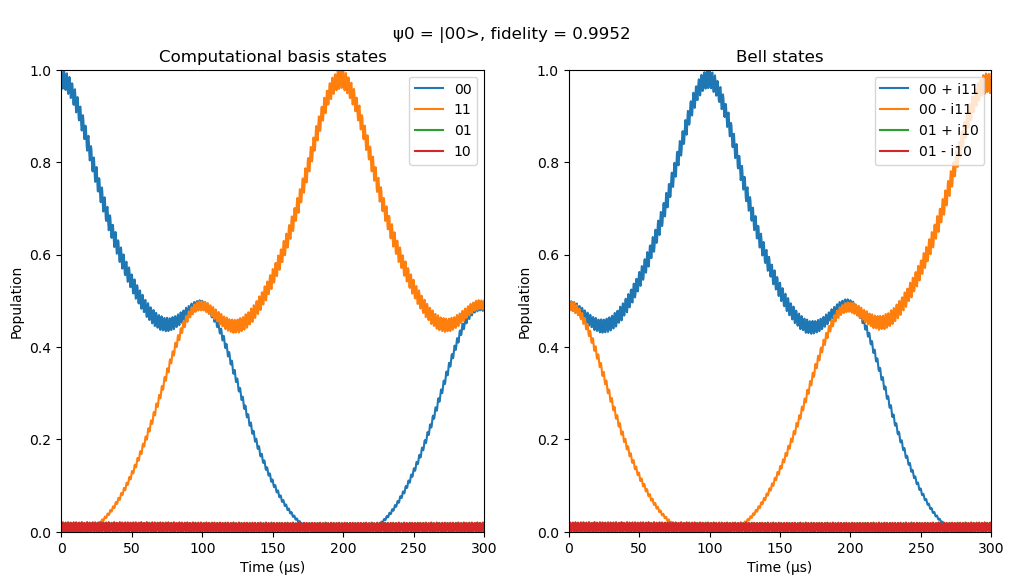

  0.332908 seconds (5.23 M allocations: 198.410 MiB, 18.40% gc time)
  0.287209 seconds (5.04 M allocations: 191.390 MiB, 9.11% gc time)


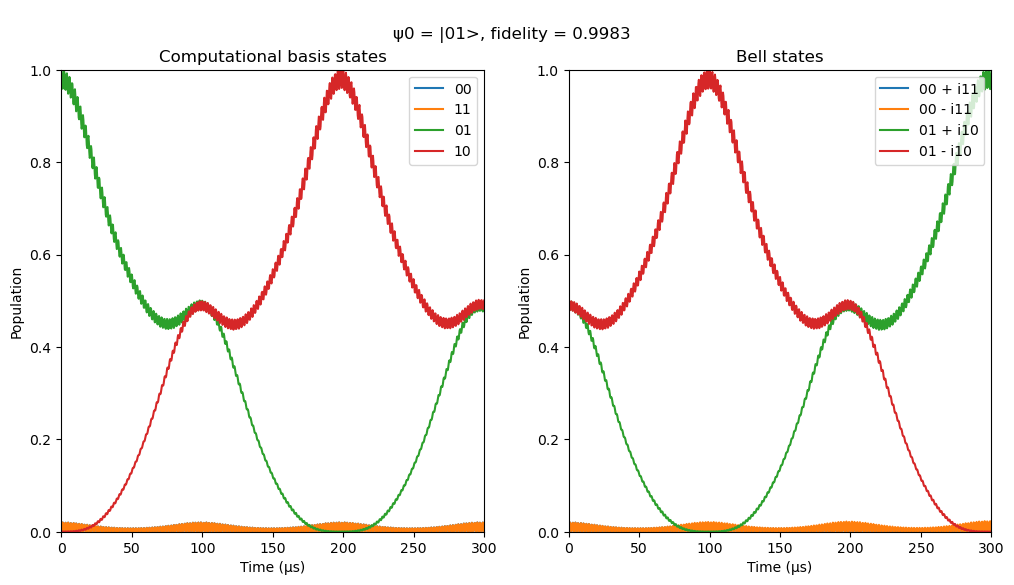

In [37]:
phase!(MS_CHAMBER_TUNED.lasers[1], 0)
phase!(MS_CHAMBER_TUNED.lasers[2], 0)

h = hamiltonian(MS_CHAMBER_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);

@time tout00, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h);
ρ_final = ptrace(dm(sol00[end]), 3)
fid = round(real(fidelity(ρ_final, ρ_00_m_i11)), digits=4)
fig = plot_populations_double(MS_CHAMBER_TUNED, tout00, sol00)
fig.suptitle("\nψ0 = |00>, fidelity = $fid")
plt.display(fig)
plt.close(fig)

@time tout01, sol01 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_01 ⊗ ket0_VIB_MODE , h);
ρ_final = ptrace(dm(sol01[end]), 3)

fid = round(real(fidelity(ρ_final, ρ_01_p_i10)), digits=4)
fig = plot_populations_double(MS_CHAMBER_TUNED, tout01, sol01)
fig.suptitle("\nψ0 = |01>, fidelity = $fid")
plt.display(fig)
plt.close(fig)


Functions to update true parameters, given measured parameters

### 1. Intensity
$\kappa = \frac{I}{\Omega^2} \Longrightarrow \Omega^2 = \frac{I}{\kappa} \Longrightarrow \Omega = \sqrt{\frac{I}{\kappa}}$

$\frac{\Omega_{\text{opt}}}{\overline{\Omega}} = \frac{\sqrt{I_{\text{opt}}/\kappa}}{\sqrt{\overline{I}/\kappa}} = \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}$

In the text, they update: $t_g \to t_g \frac{\Omega_{\text{opt}}}{\overline{\Omega}}$

Since $t_g \sim I$, here we will update: $\boxed{I \to I \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}}$

### 2. Center-line frequency

In the text, they update: $f_{\text{cl}} \to f_{\text{cl}} - (  \overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}} )$. 

**Mind the confusing notation**: here, $\omega_{\text{cl}}$ is not an angular frequency, they just use $\omega$ to denote the center-line *detuning* as opposed to the center-line frequency. With this in mind, it's clear that $\overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}}$ is exactly equivalent to $ \overline{f}_{\text{cl}} - f_{\text{cl, opt}}$. 

So we will update: $\boxed{f_{\text{cl}} \to f_{\text{cl}} - ( \overline{f}_{\text{cl}} - f_{\text{cl, opt}} )}$

### 3. Trap-frequency

In the text, they update: $f_{\text{sb}} \to f_{\text{sb}} - ( \overline{\delta} - \delta_{\text{opt}})$

So, once again, we simply update: $\boxed{\nu \to \nu - (\overline{\nu} - \nu_{\text{opt}})}$

### 4. Phase
$\boxed{\varphi \to \varphi - (\overline{\Delta \varphi} - \Delta \varphi_{\text{opt}})}$

In [38]:
# Intensity
function compute_I_new(chamber, I_bar)
    I = chamber.lasers[1].I(0)
    return I*sqrt(μ_I/I_bar)
end

function update_intensity(chamber, I_new)
    intensity!(chamber.lasers[1], I_new)
    intensity!(chamber.lasers[2], I_new)
end

# Center-line frequency 
function compute_f_cl_new(chamber, f_cl_bar)
    λ_cl = chamber.lasers[1].λ
    f_cl = C0/λ_cl
    return f_cl - (f_cl_bar - μ_f_cl)
end

function update_f_cl(chamber, f_cl_new)
    wavelength!(chamber.lasers[1], C0/f_cl_new)
    wavelength!(chamber.lasers[2], C0/f_cl_new)
end

# Trap-frequency
function compute_ν_new(chamber, ν_bar)
    ν = chamber.iontrap.comfrequencies.z
    return ν - (ν_bar - μ_ν)
end

function update_ν(chamber, ν_new)
    # Can't update the trap-frequency in-place
    # Must create a brand new chamber, with all the same properties except for the trap frequency
    I = chamber.lasers[1].I(0)
    λ_cl = chamber.lasers[1].λ
    chamber_new = construct_MS_chamber(
        ν_new,
        I,
        λ_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )

    # Recall: The detuning is based on the *target* trap-frequency
    chamber.lasers[1].Δ = μ_ν + DETUNING - AC_CORRECTION
    chamber.lasers[2].Δ = -(μ_ν + DETUNING - AC_CORRECTION)
    return chamber_new
end 

# Phase
function compute_ϕ_new(chamber, ϕ_bar)
    ϕ = chamber.lasers[2].ϕ(0)
    return ϕ - (ϕ_bar - μ_ϕ)
end

function update_ϕ(chamber, ϕ_new)
    phase!(chamber.lasers[2], ϕ_new)
end
 

update_ϕ (generic function with 1 method)

Run the noise-sim to check our parameter-update functions

In [39]:
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    μ_ν,
    μ_I,
    C0/μ_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
N_SAMPLES_TEST = Int(1e3)

fidelities = zeros(N_SAMPLES_TEST)
entanglement_entropies = zeros(N_SAMPLES_TEST)
for i in 1:N_SAMPLES_TEST
    if i%Int(1e2)==0
        print("\n", i)
        flush(stdout)
    end

    I_new = rand(Normal_I)[1]
    if I_new<0
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
        continue
    end

    f_cl_new = rand(Normal_f_cl)[1]
    λ_cl_new = C0/f_cl_new
    δλ = abs(WAVELENGTH_CL_MS - λ_cl_new)
    if δλ > δλ_MAX
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
        continue
    end

    ν_new = rand(Normal_ν)[1]

    ϕ_new = rand(Normal_ϕ)[1]
    
    try
        # actual trap-frequency is ν
        update_intensity(MS_CHAMBER_UNTUNED, I_new)
        update_f_cl(MS_CHAMBER_UNTUNED, f_cl_new)
        update_ϕ(MS_CHAMBER_UNTUNED, ϕ_new)
        MS_CHAMBER_UNTUNED = update_ν(MS_CHAMBER_UNTUNED, ν_new)
        

        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
        ρ_final = dm(sol[end])
        ρ_final_electronic = ptrace(ρ_final, 3)
        fid_i = fidelity(ρ_final_electronic, ρ_00_p_i11)
        S_i = entropy_vn(ρ_final_electronic)

        #@assert imag(fid) < 1e-8
        fidelities[i] = real(fid_i)
        entanglement_entropies[i] = S_i
    catch
        fidelities[i] = NaN
        entanglement_entropies[i] = NaN
    end
end

fidelities = fidelities[.~isnan.(fidelities)]
print("\nlength(fidelities) = ", length(fidelities))

entanglement_entropies = entanglement_entropies[.~isnan.(entanglement_entropies)]
print("\nlength(entanglement_entropies) = ", length(entanglement_entropies))

MS_CHAMBER_UNTUNED = Nothing;


100
200
300
400
500
600
700
800
900
1000
length(fidelities) = 998
length(entanglement_entropies) = 998

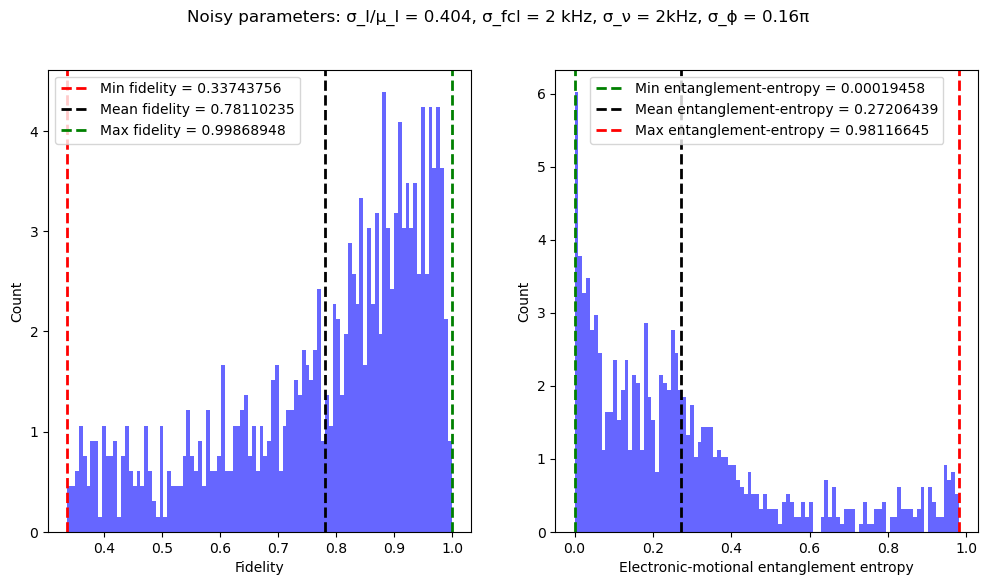

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.hist(fidelities, bins=100, density=true, alpha=0.6, color="b")
ax1.axvline(minimum(fidelities), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities); digits=8))")
ax1.axvline(mean(fidelities), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities); digits=8))")
ax1.axvline(maximum(fidelities), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities); digits=8))")
ax1.set_xlabel("Fidelity")
ax1.set_ylabel("Count")
ax1.legend()

ax2.hist(entanglement_entropies, bins=100, density=true, alpha=0.6, color="b")
ax2.axvline(minimum(entanglement_entropies), color="g", linestyle="--", linewidth=2, label="Min entanglement-entropy = $(round(minimum(entanglement_entropies); digits=8))")
ax2.axvline(mean(entanglement_entropies), color="k", linestyle="--", linewidth=2, label="Mean entanglement-entropy = $(round(mean(entanglement_entropies); digits=8))")
ax2.axvline(maximum(entanglement_entropies), color="r", linestyle="--", linewidth=2, label="Max entanglement-entropy = $(round(maximum(entanglement_entropies); digits=8))")
ax2.set_xlabel("Electronic-motional entanglement entropy")
ax2.set_ylabel("Count")
ax2.legend()

fig.suptitle("Noisy parameters: σ_I/μ_I = 0.404, σ_fcl = 2 kHz, σ_ν = 2kHz, σ_ϕ = 0.16π")
plt.display(fig)
plt.close(fig)

# 1. 1D Bayesian parameter calibration: Intensity

$ P(\Theta|m) \propto P(m|\Theta) P(\Theta)$, up to some normalization

"The Bayesian inference requires an initial prior (i.e. $P(\Theta)$), and we must choose an initial set of particles to represent this prior. We choose a known continuous probability density function as prior."

For us: $\Theta = (I) \Longrightarrow P(\Theta) \sim \mathcal{N}(\mu_I, \sigma_I) $

$\Longrightarrow \boxed{P(\Theta) = \frac{1}{\sqrt{2\pi \sigma_I}} \exp\left[-\frac{1}{2}  \frac{(i - \mu_I)^2}{\sigma_I^2} \right]}  $

"We can then initialize the particle filter from that probability function by randomly sampling $N_p$ times from the distribution and setting all the weights to $1/N_p$."


## 1.a. Compute the initial prior

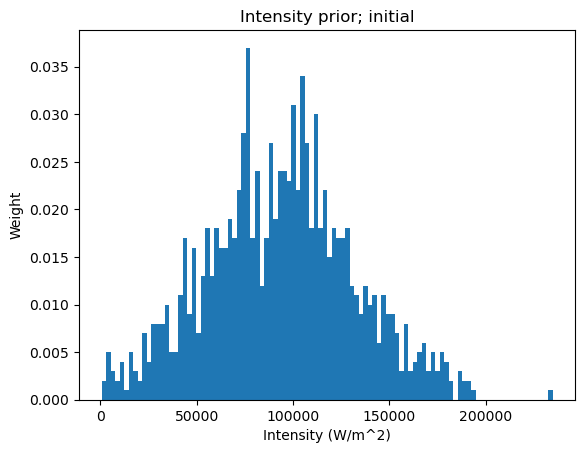

In [41]:
particles_I_1d = []
weights_I_1d = []

n_collected_I_1d = 0
while n_collected_I_1d < N_PARTICLES
    I_new = rand(Normal_I)[1]
    if I_new<0
        continue
    end

    append!(particles_I_1d, I_new)
    append!(weights_I_1d, 1.0)
    n_collected_I_1d += 1
end

weights_I_1d = weights_I_1d ./ sum(weights_I_1d);

particles_I_1d_binned, weights_I_1d_binned, binwidth_I_1d = bin_prior(particles_I_1d, weights_I_1d, 100)
fig = plt.figure()
plt.bar(particles_I_1d_binned, weights_I_1d_binned, width = binwidth_I_1d)
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Weight")
plt.title("Intensity prior; initial")
plt.display(fig)
plt.close(fig)

The $\texttt{weights\_1d}$ distribution is what gets updated throughout the calibration process. At each sample point $\widetilde{\Theta}^{(i)} \in \texttt{particles\_I\_1d}$, the relevant weight $w^{(i)} \in \texttt{weights\_1d}$ is updated according to:

$w_m^{(i)} \propto P(m|\widetilde{\Theta}^{(i)}) w^{(i)}$ 

(again, up to some normalization).

Now, there are two ways to *obtain* these $P(m|\widetilde{\Theta}^{(i)})$:
1. Numerical simulation at each discrete sample point.
2. Numerical simulation of an equally-spaced grid, then interpolation. 

In the paper, they go with the later because it's computationally cheaper. 

Here, we will go with the former because it's simpler and we are only calibrating one parameter.

## 1.b. Compute $P(m|\Theta)$

### 1.b.i. Define our measurement protocol $m$

"We restrict our considerations to sequences of MS gates without any local operations. Besides the number of gates $N_g$ we can also intentionally introduce a phase difference $\Delta \varphi_{\text{target}}$ between the gates. We restrict the phase difference settings to either $\Delta \varphi_{\text{target}} = 0$ or $\Delta \varphi_{\text{target}} = \pm \pi/4$, corresponding to either consecutive $U_{\text{MS}}^0 (\pi/2)$ gates or a sequence of $U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pm \pi/4} (\pi/2) ... U_{\text{MS}}^{\pm (N_g-1)\pi/4} (\pi/2) $ gates. We choose these two types of sequences as they change which parameters the sequence is most sensitive to (Fig. 6)."

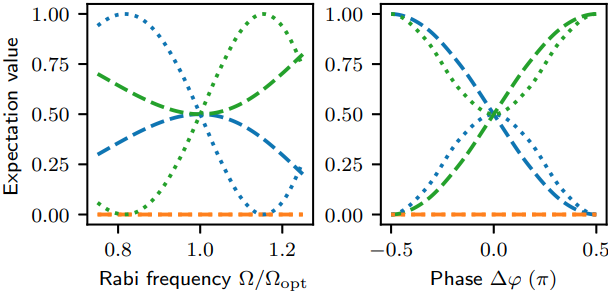

"FIG. 6. Expected outcome probabilities of $P(\ket{|g, g})$ (green), $P(\ket{|e, e})$  (blue), and $P(\ket{|e, g})  + P(\ket{|g, e})$ (orange) for a 3 $U_{\text{MS}}^0 (\pi/2)$ gate sequence (dotted) and for a $ U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pi/4} (\pi/2) $ sequence (dashed). The first gate sequence is first-order insensitive to phase miscalibrations as the local minimum of the outcome probabilities around zero leads to only small variations in the likelihood of possible outcomes, and its symmetry around zero does not allow one to discriminate the sign of the miscalibration. Similar arguments can be used to see that this sequence is first-order sensitive to Rabi frequency miscalibrations. For the second gate sequence, the relation is inverted, being sensitive to phase miscalibrations at the cost of first-order insensitivity to the Rabi frequency. The qualitative behavior of the sensitivity of the center line matches the sensitivity of the phase difference, while the behavior of the sideband detuning matches the Rabi frequency."

Since we're not varying phase right now, let's stick with the first sequence of gates:
$N_g = 3 \Longrightarrow \boxed{m = U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2)} = U_{\text{MS}}^0 (3\pi/2)$

**TODO**: Consider a weighted-combination of Rabi-sensitive and phase-sensitive gates

**TODO**: Consider 50-50 split of $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{00} + i\ket{11}\right)$ and $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{01} + i\ket{10}\right)$ (or something else since this assumes perfect preparation of the initial state?)

### 1.b.ii. Compute $P(m|\widetilde{\Theta}^{(i)})$ by sampling $\texttt{particles\_I\_1d}$ and numerically integrating at that point.

**TODO:** Introduce depolarizing noise to account for SPAM error.

In [42]:
CONDITIONAL_I_DIST_COMPUTED = true

true

In [44]:
if CONDITIONAL_I_DIST_COMPUTED
    m_given_I_1d_dist = load_csv_to_matrix("m_given_I_1d_dist_$N_PARTICLES.csv")
else
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        μ_ν,
        μ_I,
        C0/μ_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    phase!(MS_CHAMBER_UNTUNED.lasers[1], μ_ϕ)
    phase!(MS_CHAMBER_UNTUNED.lasers[2], μ_ϕ)

    m_given_I_1d_dist = zeros((N_PARTICLES, 4))

    for i in 1:N_PARTICLES

        if i%Int(1e2)==0
            print("\n", i)
            flush(stdout)
        end

        I_i = particles_I_1d[i]
        update_intensity(MS_CHAMBER_UNTUNED, I_i)

        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
        ρ_final = ptrace(dm(sol[end]),3)
        probs = ZZ_probs(ρ_final)
        probs = probs ./ sum(probs)
        m_given_I_1d_dist[i, :] = [p for p in probs]
        
    end
    writedlm("m_given_I_1d_dist_$N_PARTICLES.csv",  m_given_I_1d_dist, ',')
    CONDITIONAL_I_DIST_COMPUTED = true
end;

## 1.c. Calibrate

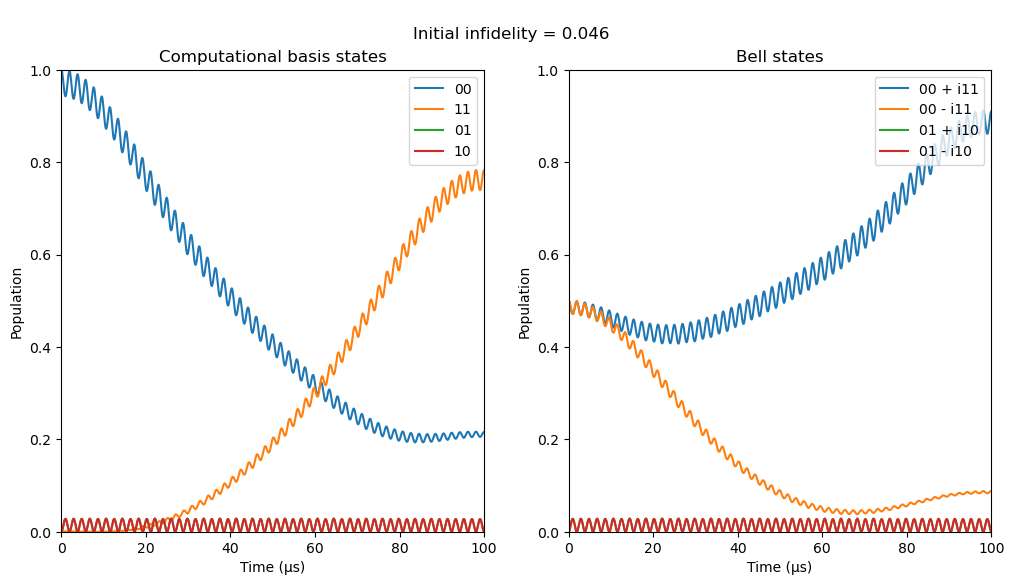

In [45]:
INFID_THRESH = 1.3e-2 # infidelity threshold
MAX_LOOPS = Int(1e3) # maximum number of loops
N_SHOTS = 100; # Number of shots per loop

# Initial theta
I_INITIAL = μ_I + σ_I
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    μ_ν,
    I_INITIAL,
    C0/μ_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], μ_ϕ)
phase!(MS_CHAMBER_UNTUNED.lasers[2], μ_ϕ)

# Initial belief about theta
I_bar = sum(particles_I_1d .* weights_I_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nInitial infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

In [47]:
loop = 0
I_infid_tracker = []
I_tracker = [I_INITIAL]
I_bar_tracker = [I_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        infid = 0
    end

    if loop%Int(1e1)==0
        print("\n", loop)
        flush(stdout)
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ = ptrace(dm(sol[end]),3)
    fid = fidelity(ρ, ρ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(ρ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_PARTICLES 
        w_i = weights_I_1d[i]
        theta_i = particles_I_1d[i]
        p_m_given_I_1d_dist = m_given_I_1d_dist[i, :]
        p_m = mean(p_m_given_I_1d_dist[m_t])
        weights_I_1d[i] = w_i * p_m
    end
    weights_I_1d = weights_I_1d ./ sum(weights_I_1d)
    I_bar = sum(particles_I_1d .* weights_I_1d)
    
    # Update parameters
    I_new = compute_I_new(MS_CHAMBER_UNTUNED, I_bar)
    I = I_new
    update_intensity(MS_CHAMBER_UNTUNED, I)

    append!(I_infid_tracker, infid)
    append!(I_tracker, I_new)
    append!(I_bar_tracker, I_bar)
    print("\nI = ", I, ", I_bar = ", I_bar, ", infid = ", infid)
    flush(stdout)


end


I = 156581.84835266223, I_bar = 96662.59073920661, infid = 0.12552569918129086
I = 154581.04674929625, I_bar = 96784.27376779189, infid = 0.11843134162018143
I = 152516.76025343244, I_bar = 96897.32710104068, infid = 0.11126147144680809
I = 150391.34707787412, I_bar = 97011.65121798731, infid = 0.104076416849191
I = 148211.0091155959, I_bar = 97122.3591003788, infid = 0.09690678578423628
I = 145978.30202556247, I_bar = 97234.1373442486, infid = 0.08979555876183132
I = 143707.5965511207, I_bar = 97331.09649226292, infid = 0.08277254971958059
I = 141408.15986699786, I_bar = 97419.29064234217, infid = 0.07590226528645094
I = 139080.9295557882, I_bar = 97509.7908671565, infid = 0.06922836100998087
10
I = 136730.78954641827, I_bar = 97597.11469567136, infid = 0.06276764792724943
I = 134363.65973170585, I_bar = 97679.50428764106, infid = 0.05654696316395269
I = 131985.18789796619, I_bar = 97756.96534455038, infid = 0.050593390976863994
I = 129593.4500659521, I_bar = 97840.51698277681, infid

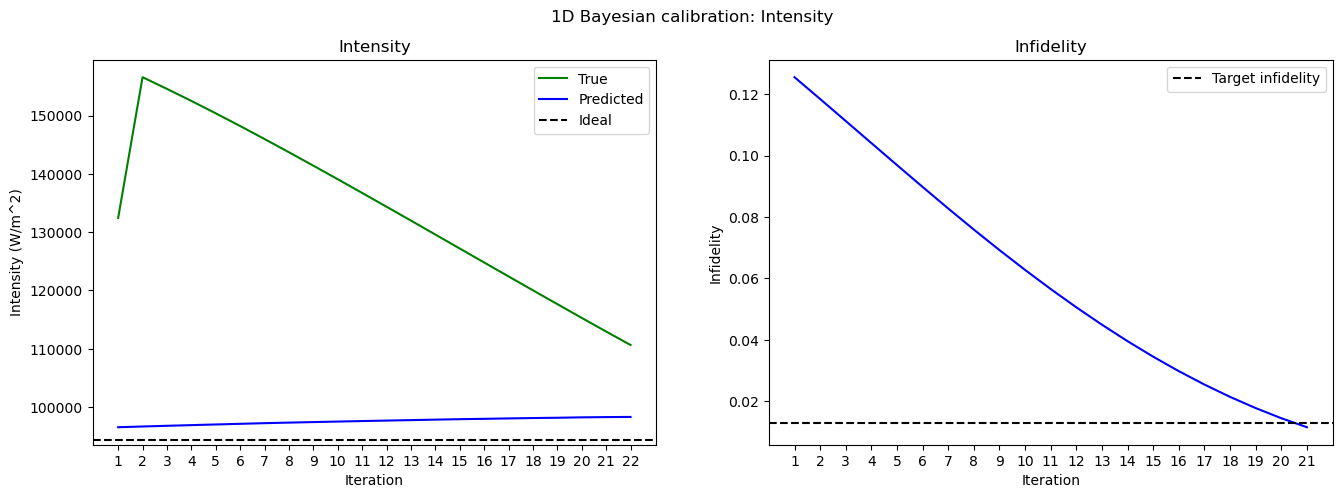

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(I_tracker), I_tracker, color="g", label = "True")
ax1.plot(1:length(I_bar_tracker), I_bar_tracker, color="b", label = "Predicted")
ax1.axhline(INTENSITY_MS, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=1:length(I_tracker))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Intensity (W/m^2)")
ax1.set_title("Intensity")
ax1.legend()


ax2.plot(1:length(I_infid_tracker), I_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=1:length(I_infid_tracker))
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Intensity")

plt.display(fig)
plt.close(fig)

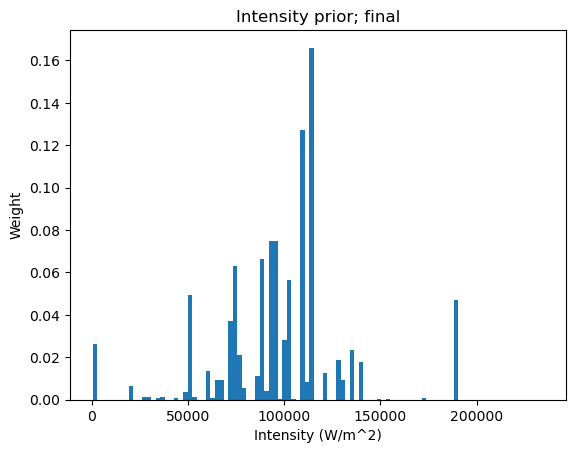

In [49]:
particles_I_1d_binned, weights_I_1d_binned, binwidth_I_1d = bin_prior(particles_I_1d, weights_I_1d, 100)
fig = plt.figure()
plt.bar(particles_I_1d_binned, weights_I_1d_binned, width = binwidth_I_1d)
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Weight")
plt.title("Intensity prior; final")
plt.display(fig)
plt.close(fig)

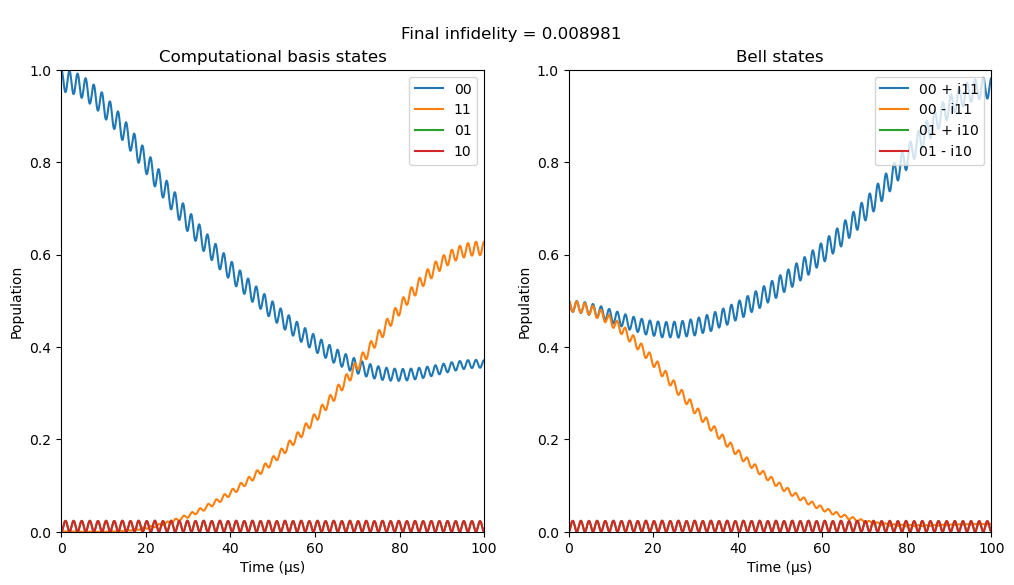


Final infidelity = 0.008981416744774595

In [50]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)
print("\nFinal infidelity = ", infid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=6)
plt.suptitle("\nFinal infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

**IMPORTANT TODO:** Investigate runaway effect when $\texttt{I\_initial} < \texttt{INTENSITY\_MS}$ and $\texttt{INFID\_THRESH}$ is too small; recall Lukas: "the way you do the sampling is tricky, but important"

# 2. 1D Bayesian parameter calibration: Center-line frequency

$\Longrightarrow \boxed{P(\Theta) = \frac{1}{\sqrt{2\pi \sigma_{f_{\text{cl}}}}} \exp\left[-\frac{1}{2}  \frac{(i - \mu_{f_{\text{cl}}})^2}{\sigma_{f_{\text{cl}}}^2} \right]}  $

## 2.a. Compute the initial prior

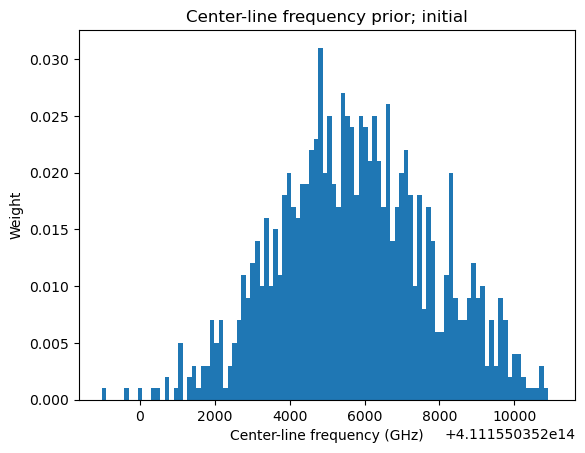

In [51]:
particles_f_cl_1d = []
weights_f_cl_1d = []

n_collected_f_cl_1d = 0
while n_collected_f_cl_1d < N_PARTICLES
    f_cl_new = rand(Normal_f_cl)[1]
    λ_cl_new = C0/f_cl_new
    δλ_cl_new = abs(C0/μ_f_cl - λ_cl_new)
    if δλ_cl_new > δλ_MAX
        continue
    end

    append!(particles_f_cl_1d, f_cl_new)
    append!(weights_f_cl_1d, 1.0)
    n_collected_f_cl_1d += 1
end

weights_f_cl_1d = weights_f_cl_1d ./ sum(weights_f_cl_1d);

particles_f_cl_1d_binned, weights_f_cl_1d_binned, binwidth_f_cl_1d = bin_prior(particles_f_cl_1d, weights_f_cl_1d, 100)
fig = plt.figure()
plt.bar(particles_f_cl_1d_binned, weights_f_cl_1d_binned, width = binwidth_f_cl_1d)
plt.xlabel("Center-line frequency (GHz)")
plt.ylabel("Weight")
plt.title("Center-line frequency prior; initial")
plt.display(fig)
plt.close(fig)

## 2.b. Compute $P(m|\Theta)$

In [52]:
CONDITIONAL_f_cl_DIST_COMPUTED = true

true

In [54]:
if CONDITIONAL_f_cl_DIST_COMPUTED
    m_given_f_cl_1d_dist = load_csv_to_matrix("m_given_f_cl_1d_dist_$N_PARTICLES.csv")
else
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        μ_ν,
        μ_I,
        C0/μ_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    phase!(MS_CHAMBER_UNTUNED.lasers[1], μ_ϕ)
    phase!(MS_CHAMBER_UNTUNED.lasers[2], μ_ϕ)

    m_given_f_cl_1d_dist = zeros((N_PARTICLES, 4))

    for i in 1:N_PARTICLES

        if i%Int(1e2)==0
            print("\n", i)
            flush(stdout)
        end

        f_cl_i = particles_f_cl_1d[i]
        update_f_cl(MS_CHAMBER_UNTUNED, f_cl_i)

        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
        ρ_final = ptrace(dm(sol[end]),3)
        probs = ZZ_probs(ρ_final)
        probs = probs ./ sum(probs)
        m_given_f_cl_1d_dist[i, :] = [p for p in probs]
    
    end
    writedlm("m_given_f_cl_1d_dist_$N_PARTICLES.csv",  m_given_f_cl_1d_dist, ',')
    CONDITIONAL_f_cl_DIST_COMPUTED = true 
end;

## 2.c. Calibrate

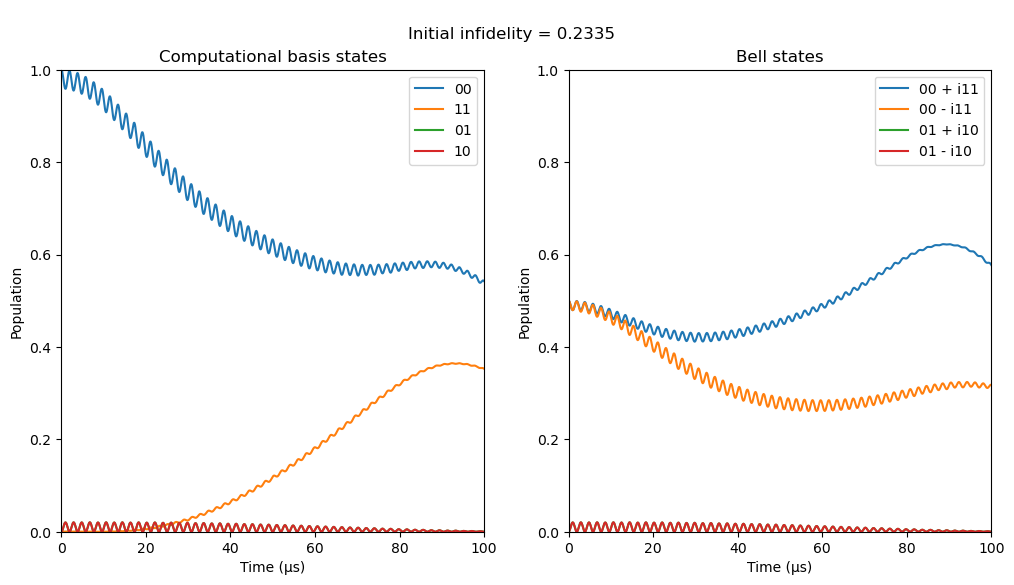


Initial infidelity = 0.2335463899139537

In [58]:
# Initial theta
F_CL_INITIAL = μ_f_cl + σ_f_cl
λ_CL_INITIAL = C0/F_CL_INITIAL
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    μ_ν,
    μ_I,
    C0/F_CL_INITIAL,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], μ_ϕ)
phase!(MS_CHAMBER_UNTUNED.lasers[2], μ_ϕ)

# Initial belief about theta
f_cl_bar = sum(particles_f_cl_1d .* weights_f_cl_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)
print("\nInitial infidelity = ", infid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nInitial infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

In [59]:
loop = 0
f_cl_infid_tracker = []
f_cl_tracker = [F_CL_INITIAL]
f_cl_bar_tracker = [f_cl_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    print("\n\nf_cl = ", C0/MS_CHAMBER_UNTUNED.lasers[1].λ, ", δλ_cl = ", abs(MS_CHAMBER_UNTUNED.lasers[1].λ - WAVELENGTH_CL_MS))

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ = ptrace(dm(sol[end]),3)
    fid = fidelity(ρ, ρ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(ρ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_PARTICLES
        w_i = weights_f_cl_1d[i]
        theta_i = particles_f_cl_1d[i]
        p_m_given_f_cl_1d_dist = m_given_f_cl_1d_dist[i, :]
        p_m = mean(p_m_given_f_cl_1d_dist[m_t])
        weights_f_cl_1d[i] = w_i * p_m
    end
    weights_f_cl_1d = weights_f_cl_1d ./ sum(weights_f_cl_1d)
    f_cl_bar = sum(particles_f_cl_1d .* weights_f_cl_1d)
    
    # Update parameters
    f_cl_new = compute_f_cl_new(MS_CHAMBER_UNTUNED, f_cl_bar)
    λ_cl_new = C0/f_cl_new
    δλ_cl_new = abs(C0/μ_f_cl - λ_cl_new)
    if δλ_cl_new > δλ_MAX
        print("Runaway into non-integrable region")
        flush(stdout)
        break
    end
    update_f_cl(MS_CHAMBER_UNTUNED, f_cl_new)

    append!(f_cl_infid_tracker, infid)
    append!(f_cl_tracker, f_cl_new)
    append!(f_cl_bar_tracker, f_cl_bar)
    print(", f_cl_bar = ", f_cl_bar, "\nf_cl_new = ", f_cl_new,  ", δλ_cl_new = ", abs(WAVELENGTH_CL_MS - C0/f_cl_new),  ", infid = ", infid)
    flush(stdout)

end



f_cl = 4.111550352077269e14, δλ_cl = 3.546738708390569e-18, f_cl_bar = 4.11155035205761e14
f_cl_new = 4.1115503520769275e14, δλ_cl_new = 3.4862817317802934e-18, infid = 0.2335463899139537

f_cl = 4.1115503520769275e14, δλ_cl = 3.4862817317802934e-18, f_cl_bar = 4.111550352057737e14
f_cl_new = 4.1115503520764594e14, δλ_cl_new = 3.403272502949372e-18, infid = 0.22732220652091772

f_cl = 4.1115503520764594e14, δλ_cl = 3.403272502949372e-18, f_cl_bar = 4.111550352057841e14
f_cl_new = 4.111550352075887e14, δλ_cl_new = 3.3017344283972627e-18, infid = 0.21885028501511483

f_cl = 4.111550352075887e14, δλ_cl = 3.3017344283972627e-18, f_cl_bar = 4.111550352057925e14
f_cl_new = 4.1115503520752306e14, δλ_cl_new = 3.1853732772682032e-18, infid = 0.20860142699063777

f_cl = 4.1115503520752306e14, δλ_cl = 3.1853732772682032e-18, f_cl_bar = 4.1115503520580094e14
f_cl_new = 4.11155035207449e14, δλ_cl_new = 3.05397729132538e-18, infid = 0.19701678389229194

f_cl = 4.11155035207449e14, δλ_cl = 3.053977

## 2.d. Analyze results

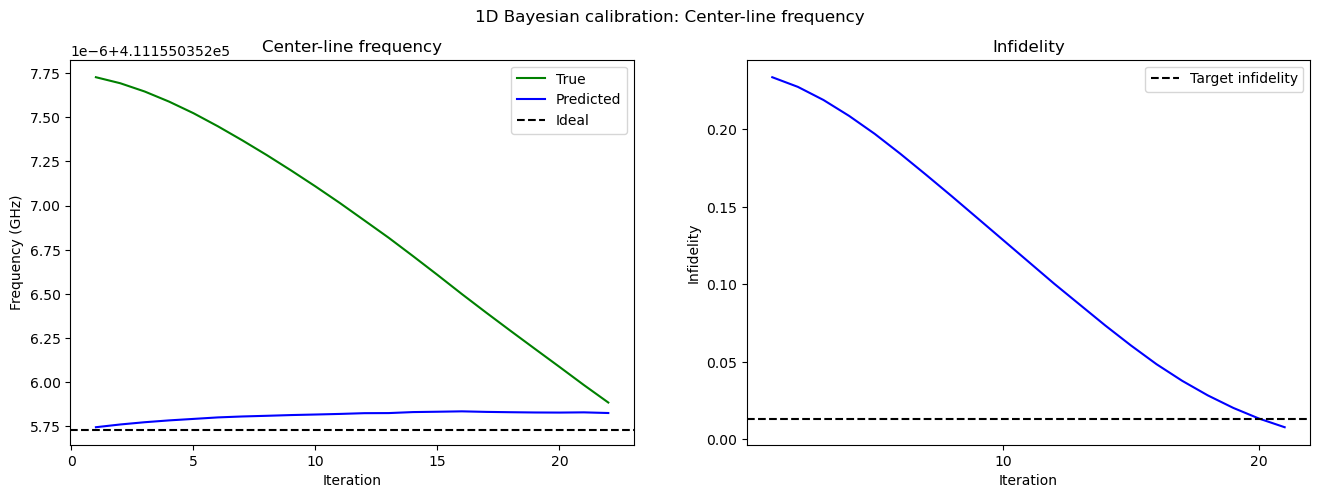

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(f_cl_tracker), f_cl_tracker*1e-9, color="g", label = "True")
ax1.plot(1:length(f_cl_bar_tracker), f_cl_bar_tracker*1e-9, color="b", label = "Predicted")
ax1.axhline(FREQUENCY_CL_MS*1e-9, color="k", linestyle="--", label = "Ideal")
ax2.set_xticks(ticks=[i for i in 1:length(f_cl_tracker) if i%10==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Frequency (GHz)")
ax1.set_title("Center-line frequency")
ax1.legend()


ax2.plot(1:length(f_cl_infid_tracker), f_cl_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(f_cl_infid_tracker) if i%10==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Center-line frequency")

plt.display(fig)
plt.close(fig)

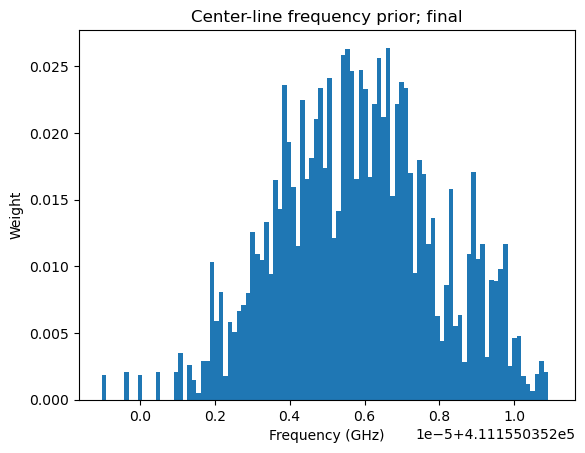

In [61]:
particles_f_cl_1d_binned, weights_f_cl_1d_binned, binwidth_f_cl_1d = bin_prior(particles_f_cl_1d, weights_f_cl_1d, 100)
fig = plt.figure()
plt.bar(particles_f_cl_1d_binned*1e-9, weights_f_cl_1d_binned, width = binwidth_f_cl_1d*1e-9)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Weight")
plt.title("Center-line frequency prior; final")
plt.display(fig)
plt.close(fig)

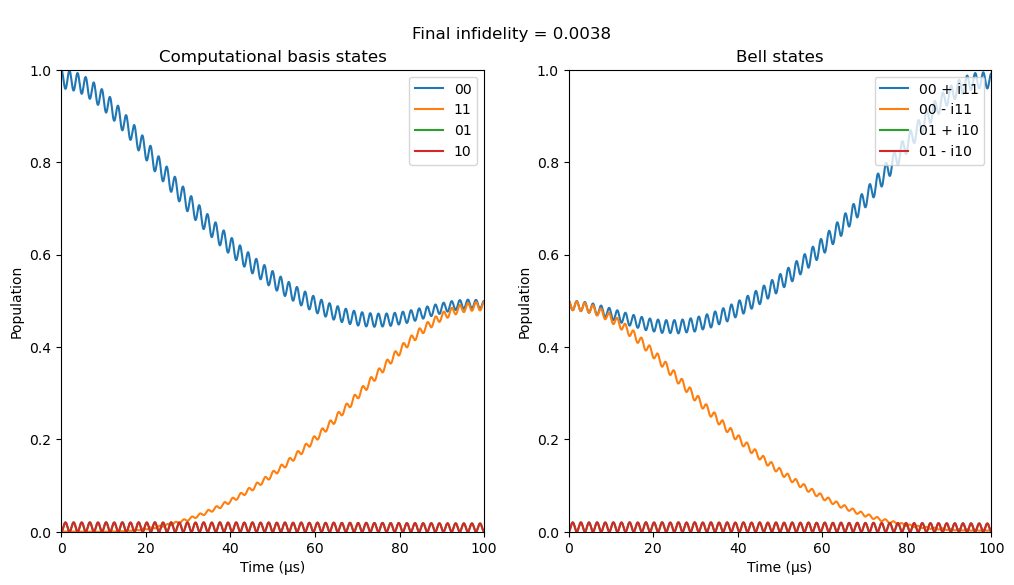

In [62]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nFinal infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

**NOTE:** Sometimes it performs better using $\texttt{FINITE\_RWA\_CUTOFF = 5}$ rather than $\texttt{Inf}$

# 3. 1D Bayesian parameter calibration: trap frequency

## 3.a. Compute the initial prior

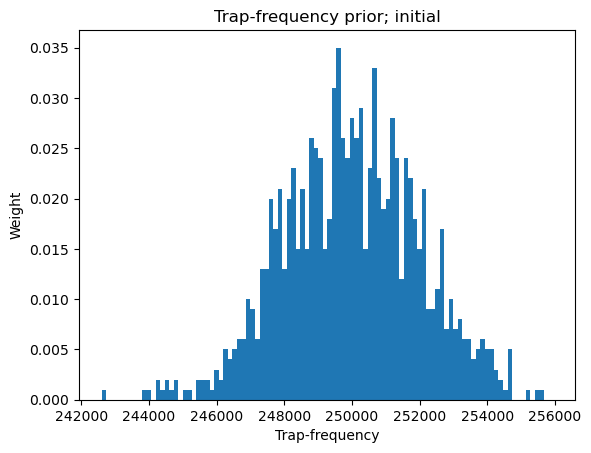

In [63]:
particles_ν_1d = []
weights_ν_1d = []

n_collected_ν_1d = 0
while n_collected_ν_1d < N_PARTICLES
    ν_new = rand(Normal_ν)[1]
    append!(particles_ν_1d, ν_new)
    append!(weights_ν_1d, 1.0)
    n_collected_ν_1d += 1
end

weights_ν_1d = weights_ν_1d ./ sum(weights_ν_1d);

particles_ν_1d_binned, weights_ν_1d_binned, binwidth_ν_1d = bin_prior(particles_ν_1d, weights_ν_1d, 100)
fig = plt.figure()
plt.bar(particles_ν_1d_binned, weights_ν_1d_binned, width = binwidth_ν_1d)
plt.xlabel("Trap-frequency")
plt.ylabel("Weight")
plt.title("Trap-frequency prior; initial")
plt.display(fig)
plt.close(fig)

## 3.b. Compute $P(m|\Theta)$

In [64]:
CONDITIONAL_ν_DIST_COMPUTED = true

true

In [65]:
if CONDITIONAL_ν_DIST_COMPUTED
    m_given_ν_1d_dist = load_csv_to_matrix("m_given_ν_1d_dist_$N_PARTICLES.csv")
else
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        μ_ν,
        μ_I,
        C0/μ_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )

    m_given_ν_1d_dist = zeros((N_PARTICLES, 4))

    for i in 1:N_PARTICLES

        if i%Int(1e2)==0
            print("\n", i)
            flush(stdout)
        end

        try
            ν_i = particles_ν_1d[i]
            MS_CHAMBER_UNTUNED = update_ν(MS_CHAMBER_UNTUNED, ν_i)
            h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
            tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
            ρ_final = ptrace(dm(sol[end]),3)
            probs = ZZ_probs(ρ_final)
            probs = probs ./ sum(probs)
            m_given_ν_1d_dist[i, :] = [p for p in probs]
        catch
            m_given_ν_1d_dist[i, :] = [NaN for p in 1:4]
            particles_ν_1d[i] = NaN
            weights_ν_1d[i] = NaN
        end
    end
    writedlm("m_given_ν_1d_dist_$N_PARTICLES.csv",  m_given_ν_1d_dist, ',')
    CONDITIONAL_ν_DIST_COMPUTED = true 
end;

In [66]:
sum(isnan.(particles_ν_1d))

0

## 3.c. Calibrate

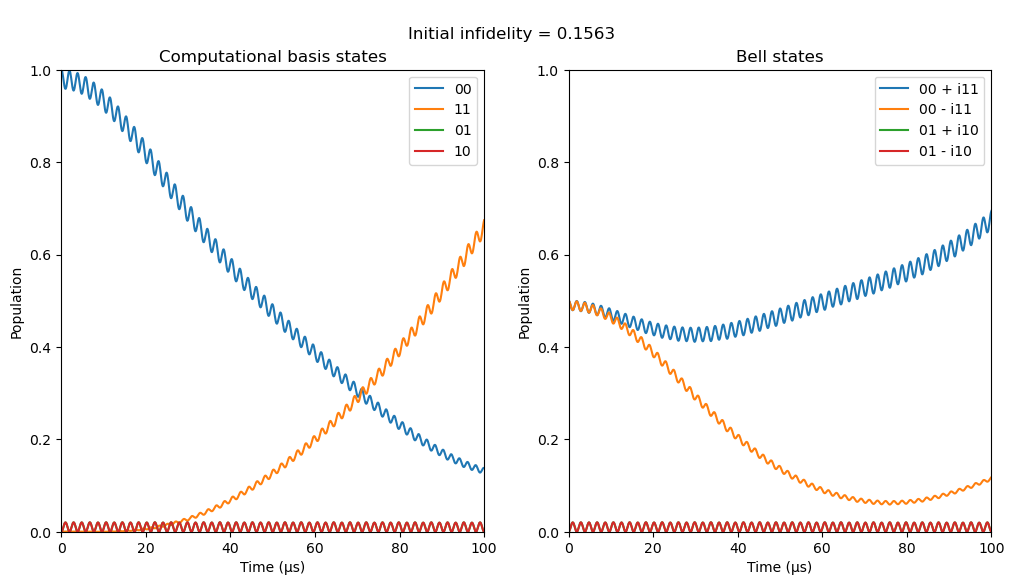

In [67]:
# Initial theta
ν_INITIAL = μ_ν + σ_ν
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    ν_INITIAL,
    μ_I,
    C0/μ_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], μ_ϕ)
phase!(MS_CHAMBER_UNTUNED.lasers[2], μ_ϕ)

# Remember, the detuning is based on the target trap-frequency, not the true trap-frequency
MS_CHAMBER_UNTUNED.lasers[1].Δ = μ_ν+ DETUNING - AC_CORRECTION
MS_CHAMBER_UNTUNED.lasers[2].Δ = -(μ_ν + DETUNING - AC_CORRECTION)

# Initial belief about theta
ν_bar = sum(particles_ν_1d .* weights_ν_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nInitial infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

In [68]:
loop = 0
ν_infid_tracker = []
ν_tracker = [ν_INITIAL]
ν_bar_tracker = [ν_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ = ptrace(dm(sol[end]),3)
    fid = fidelity(ρ, ρ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(ρ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_PARTICLES
        w_i = weights_ν_1d[i]
        theta_i = particles_ν_1d[i]
        p_m_given_ν_1d_dist = m_given_ν_1d_dist[i, :]
        p_m = mean(p_m_given_ν_1d_dist[m_t])
        weights_ν_1d[i] = w_i * p_m
    end
    weights_ν_1d = weights_ν_1d ./ sum(weights_ν_1d)
    ν_bar = sum(particles_ν_1d .* weights_ν_1d)
    
    # Update parameters
    ν_new = compute_ν_new(MS_CHAMBER_UNTUNED, ν_bar)
    MS_CHAMBER_UNTUNED = update_ν(MS_CHAMBER_UNTUNED, ν_new)

    append!(ν_infid_tracker, infid)
    append!(ν_tracker, ν_new)
    append!(ν_bar_tracker, ν_bar)
    print("\nν_bar = ", ν_bar, ", ν_new = ", ν_new, ", infid = ", infid)
    flush(stdout)


end


ν_bar = 249983.66272880888, ν_new = 252016.33727119112, infid = 0.15626428554191374
ν_bar = 249984.83694627762, ν_new = 252031.5003249135, infid = 0.01856412577123867
ν_bar = 249985.9833299507, ν_new = 252045.51699496282, infid = 0.018665466655771512
ν_bar = 249987.1589157352, ν_new = 252058.35807922762, infid = 0.01875593111181484
ν_bar = 249988.31493385253, ν_new = 252070.0431453751, infid = 0.018837162114763606
ν_bar = 249989.47501441097, ν_new = 252080.56813096412, infid = 0.01890877812434555
ν_bar = 249990.6374743214, ν_new = 252089.9306566427, infid = 0.01897133610851598
ν_bar = 249991.7909742852, ν_new = 252098.13968235752, infid = 0.019026181101074457
ν_bar = 249992.86842494868, ν_new = 252105.27125740884, infid = 0.01907286064891056
ν_bar = 249994.05193518964, ν_new = 252111.2193222192, infid = 0.019112808051747088
ν_bar = 249995.17407817728, ν_new = 252116.04524404192, infid = 0.01914631776798892
ν_bar = 249996.29391252447, ν_new = 252119.75133151744, infid = 0.0191724360943

## 3.d. Analyze results

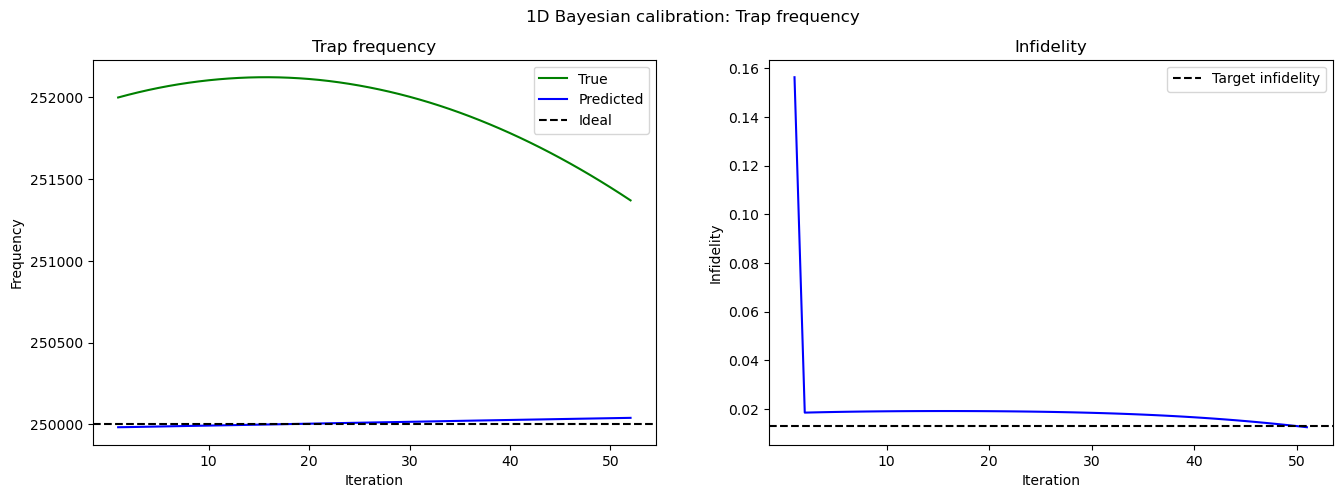

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(ν_tracker), ν_tracker, color="g", label = "True")
ax1.plot(1:length(ν_bar_tracker), ν_bar_tracker, color="b", label = "Predicted")
ax1.axhline(TRAP_FREQUENCY, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=[i for i in 1:length(ν_infid_tracker) if i%10==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Frequency")
ax1.set_title("Trap frequency")
ax1.legend()


ax2.plot(1:length(ν_infid_tracker), ν_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(ν_infid_tracker) if i%10==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Trap frequency")

plt.display(fig)
plt.close(fig)

**TODO:** This is weird. Why does fidelity decrease as trap-frequency strays from the "ideal"?

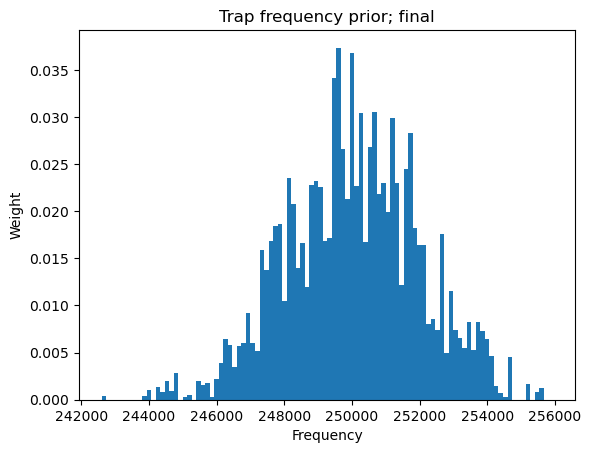

In [70]:
particles_ν_1d_binned, weights_ν_1d_binned, binwidth_ν_1d = bin_prior(particles_ν_1d, weights_ν_1d, 100)
fig = plt.figure()
plt.bar(particles_ν_1d_binned, weights_ν_1d_binned, width = binwidth_ν_1d)
plt.xlabel("Frequency")
plt.ylabel("Weight")
plt.title("Trap frequency prior; final")
plt.display(fig)
plt.close(fig)

**Interesting:** Sidebands in the trap-frequency but not the center-line frequency?

Also interesting that it displays such distinct structure after not many (e.g. 6) iterations.

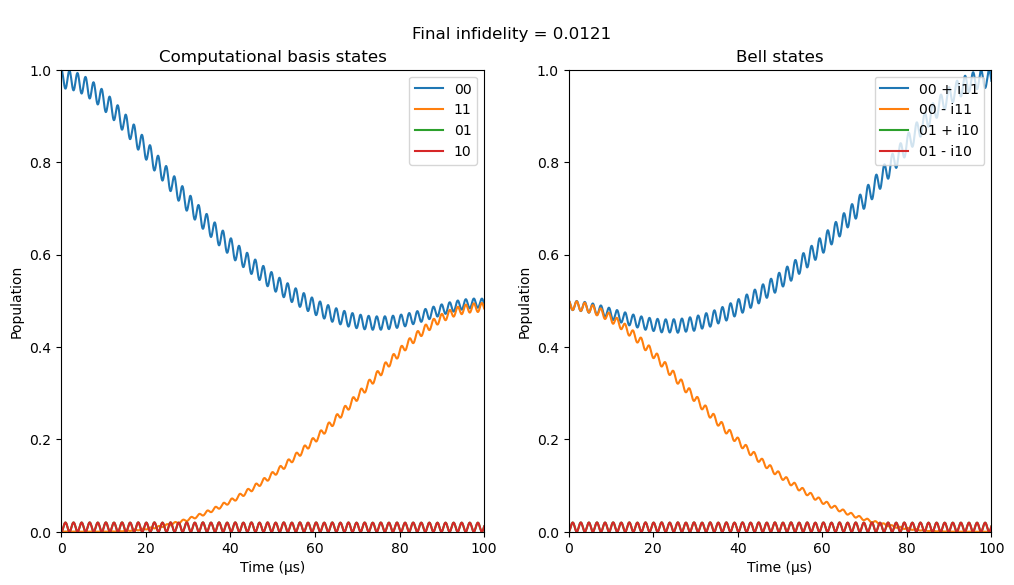

In [71]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nFinal infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

# 4. 1D Bayesian parameter calibration: Phase of lasers

## 4.a. Compute initial prior

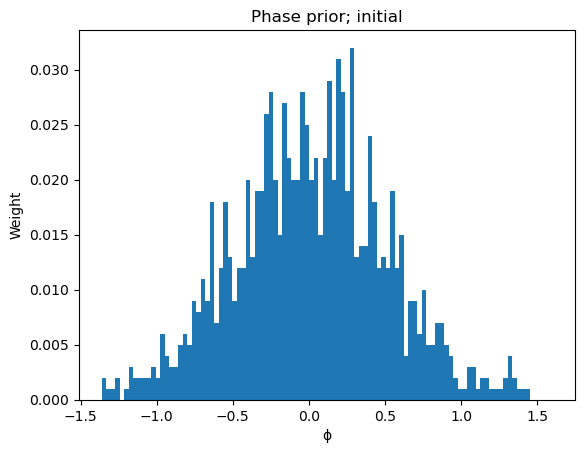

In [72]:
particles_ϕ_1d = []
weights_ϕ_1d = []

n_collected_ϕ_1d = 0
while n_collected_ϕ_1d < N_PARTICLES
    ϕ_new = rand(Normal_ϕ)[1]
    append!(particles_ϕ_1d, ϕ_new)
    append!(weights_ϕ_1d, 1.0)
    n_collected_ϕ_1d += 1
end

weights_ϕ_1d = weights_ϕ_1d ./ sum(weights_ϕ_1d);

particles_ϕ_1d_binned, weights_ϕ_1d_binned, binwidth_ϕ_1d = bin_prior(particles_ϕ_1d, weights_ϕ_1d, 100)
fig = plt.figure()
plt.bar(particles_ϕ_1d_binned, weights_ϕ_1d_binned, width = binwidth_ϕ_1d)
plt.xlabel("ϕ")
plt.ylabel("Weight")
plt.title("Phase prior; initial")
plt.display(fig)
plt.close(fig)

## 4.b. Compute $P(m|\Theta)$

In [73]:
CONDITIONAL_ϕ_DIST_COMPUTED = true

true

In [74]:
if CONDITIONAL_ϕ_DIST_COMPUTED
    m_given_ϕ_1d_dist = load_csv_to_matrix("m_given_ϕ_1d_dist_$N_PARTICLES.csv")
else
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        μ_ν,
        μ_I,
        μ_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    phase!(MS_CHAMBER_UNTUNED.lasers[1], 0)

    m_given_ϕ_1d_dist = zeros((N_PARTICLES, 4))

    for i in 1:length(particles_ϕ_1d)

        if i%Int(1e2)==0
            print("\n", i)
            flush(stdout)
        end


        ϕ_i = particles_ϕ_1d[i]
        phase!(MS_CHAMBER_UNTUNED.lasers[2], ϕ_i)
        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
        ρ_final = ptrace(dm(sol[end]),3)
        probs = ZZ_probs(ρ_final)
        probs = probs ./ sum(probs)
        m_given_ϕ_1d_dist[i, :] = [p for p in probs]
    end
    writedlm("m_given_ϕ_1d_dist_$N_PARTICLES.csv",  m_given_ϕ_1d_dist, ',')
    CONDITIONAL_ϕ_DIST_COMPUTED = true
end;

## 4.c. Calibrate

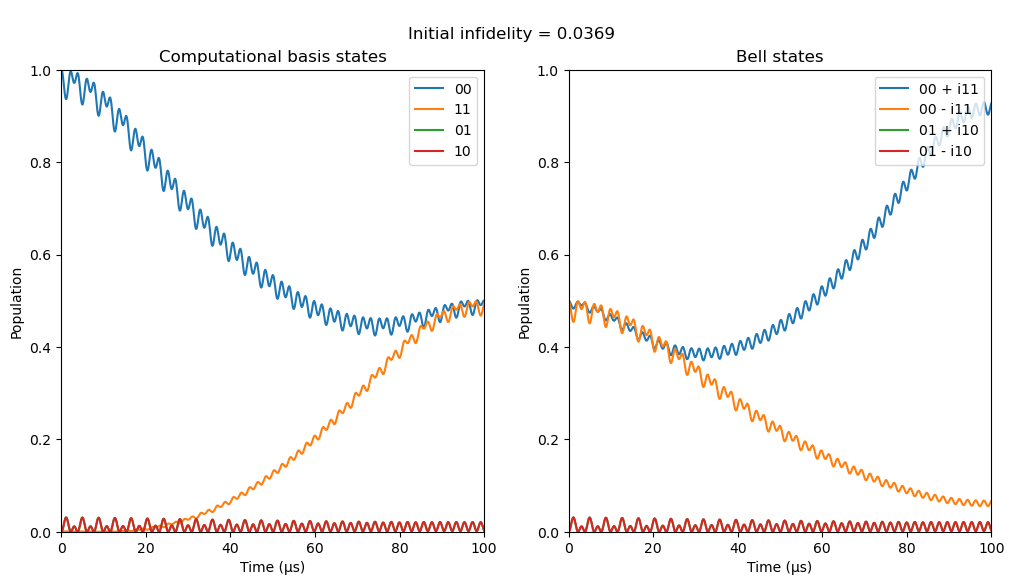

In [75]:
# Initial theta
ϕ_INITIAL = PHASE + σ_ϕ
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    μ_ν,
    μ_I,
    C0/μ_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], 0)
phase!(MS_CHAMBER_UNTUNED.lasers[2], ϕ_INITIAL)

# Initial belief about theta
ϕ_bar = sum(particles_ϕ_1d .* weights_ϕ_1d)

# Initial fidelity/infidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nInitial infidelity = $infid_title")
plt.display(fig)
plt.close(fig)

In [76]:
loop = 0
ϕ_infid_tracker = []
ϕ_tracker = [ϕ_INITIAL]
ϕ_bar_tracker = [ϕ_bar]
while infid > INFID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
    ρ = ptrace(dm(sol[end]),3)
    fid = fidelity(ρ, ρ_00_p_i11)
    infid = 1 - real(fid)
    probs = ZZ_probs(ρ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    for i in 1:N_PARTICLES
        w_i = weights_ϕ_1d[i]
        theta_i = particles_ϕ_1d[i]
        p_m_given_ϕ_1d_dist = m_given_ϕ_1d_dist[i, :]
        p_m = mean(p_m_given_ϕ_1d_dist[m_t])
        weights_ϕ_1d[i] = w_i * p_m
    end
    weights_ϕ_1d = weights_ϕ_1d ./ sum(weights_ϕ_1d)
    ϕ_bar = sum(particles_ϕ_1d .* weights_ϕ_1d)
    
    # Update parameters
    ϕ_new = compute_ϕ_new(MS_CHAMBER_UNTUNED, ϕ_bar)%2π
    update_ϕ(MS_CHAMBER_UNTUNED, ϕ_new)

    append!(ϕ_infid_tracker, infid)
    append!(ϕ_tracker, ϕ_new)
    append!(ϕ_bar_tracker, ϕ_bar)
    print("\nϕ_bar = ", ϕ_bar, ", ϕ_new = ", ϕ_new, ", infid = ", infid)
    flush(stdout)

end


ϕ_bar = 0.011519174893647757, ϕ_new = 0.4911356496807192, infid = 0.03694916253635472
ϕ_bar = 0.011798271115596915, ϕ_new = 0.4793373785651223, infid = 0.03539748867958514
ϕ_bar = 0.012048920431521355, ϕ_new = 0.467288458133601, infid = 0.0338415016356457
ϕ_bar = 0.012311322505408555, ϕ_new = 0.4549771356281924, infid = 0.032287335589327615
ϕ_bar = 0.01254140105317447, ϕ_new = 0.44243573457501795, infid = 0.03073586853208443
ϕ_bar = 0.012746052755422236, ϕ_new = 0.4296896818195957, infid = 0.029193541209041163
ϕ_bar = 0.01299958756770804, ϕ_new = 0.4166900942518877, infid = 0.02766561286456093
ϕ_bar = 0.013258672414839995, ϕ_new = 0.4034314218370477, infid = 0.02614855104511471
ϕ_bar = 0.013461783919686736, ϕ_new = 0.389969637917361, infid = 0.02464431562975289
ϕ_bar = 0.013681345196072081, ϕ_new = 0.37628829272128894, infid = 0.0231617136717559
ϕ_bar = 0.013911250092879563, ϕ_new = 0.36237704262840936, infid = 0.02170121925552082
ϕ_bar = 0.014122521668545324, ϕ_new = 0.34825452095986

## 4.d. Analyze results

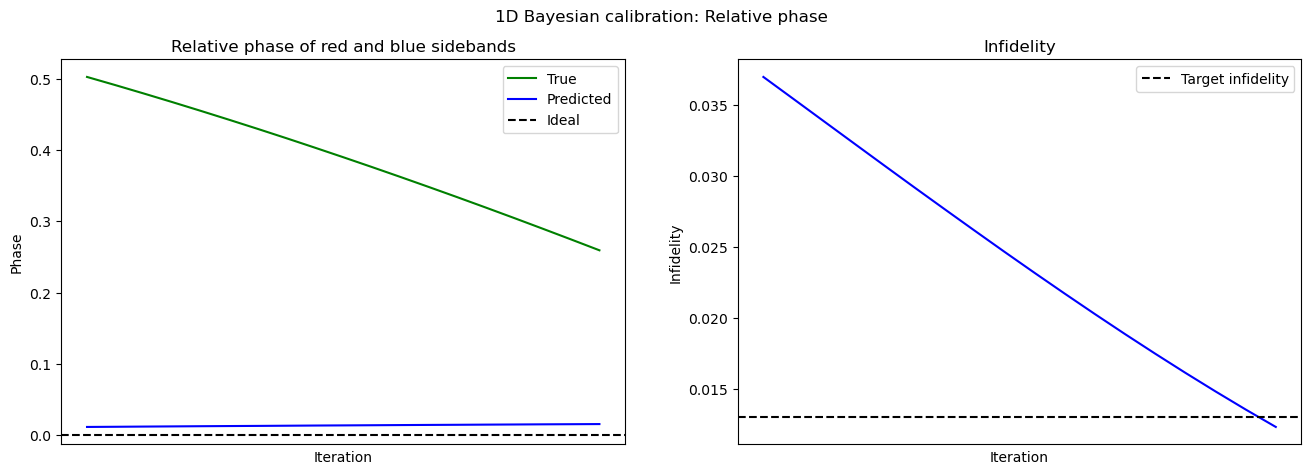

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.plot(1:length(ϕ_tracker), ϕ_tracker, color="g", label = "True")
ax1.plot(1:length(ϕ_bar_tracker), ϕ_bar_tracker, color="b", label = "Predicted")
ax1.axhline(PHASE, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=[i for i in 1:length(ϕ_tracker) if i%100==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Phase")
ax1.set_title("Relative phase of red and blue sidebands")
ax1.legend()


ax2.plot(1:length(ϕ_infid_tracker), ϕ_infid_tracker, color="b")
ax2.axhline(INFID_THRESH, label = "Target infidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(ϕ_infid_tracker) if i%100==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Infidelity")
ax2.set_title("Infidelity")
ax2.legend()

fig.suptitle("1D Bayesian calibration: Relative phase")

plt.display(fig)
plt.close(fig)

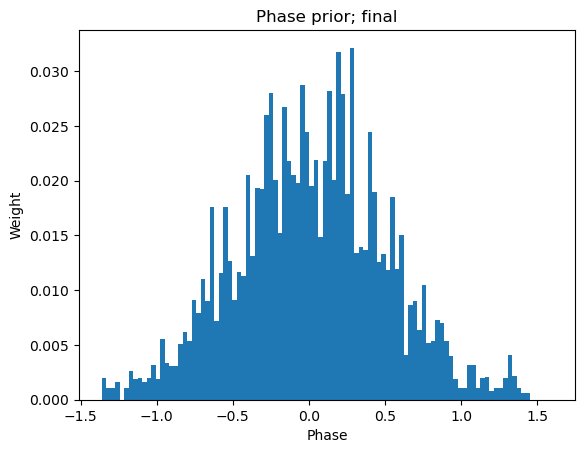

In [78]:
particles_ϕ_1d_binned, weights_ϕ_1d_binned, binwidth_ϕ_1d = bin_prior(particles_ϕ_1d, weights_ϕ_1d, 100)
fig = plt.figure()
plt.bar(particles_ϕ_1d_binned, weights_ϕ_1d_binned, width = binwidth_ϕ_1d)
plt.xlabel("Phase")
plt.ylabel("Weight")
plt.title("Phase prior; final")
plt.display(fig)
plt.close(fig)

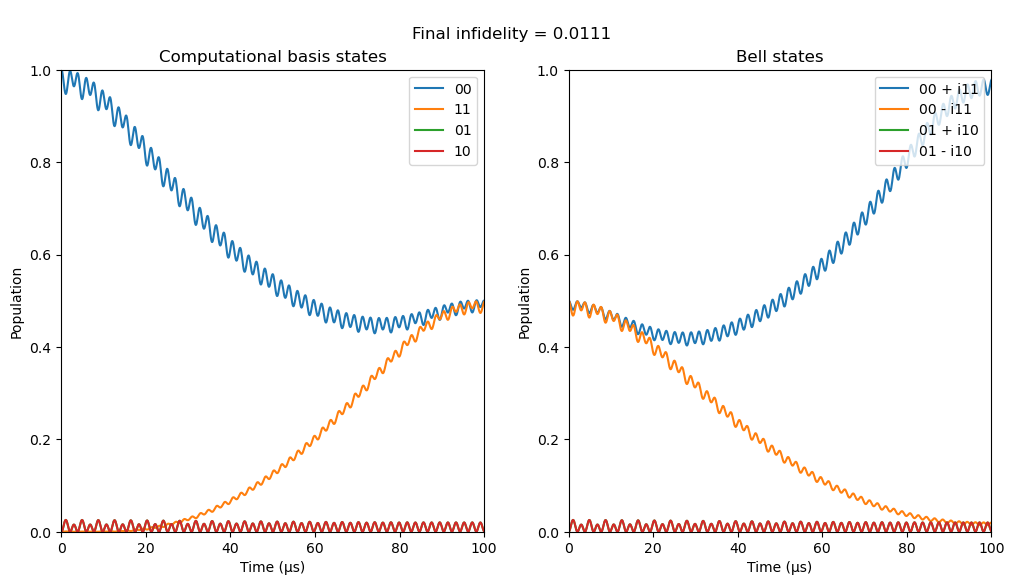

In [79]:
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ⊗ ket0_VIB_MODE, h)
ρ = ptrace(dm(sol[end]),3)
fid = fidelity(ρ, ρ_00_p_i11)
infid = 1 - real(fid)

fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
infid_title = round(infid, digits=4)
plt.suptitle("\nFinal infidelity = $infid_title")
plt.display(fig)
plt.close(fig)